In [1]:

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

import sys
sys.path.append("/Users/clemens/Documents/courses/DS-Lab/Baselines")

import gp_features

In [2]:
used_from_gp = pd.read_csv("../Baselines/events_used_by_gp.csv")
info = pd.read_csv("../Baselines/gp_run_info_dict.csv")
# used_from_gp.loc[:, 'answer_id'] = info.answer_id
# used_from_gp.loc[:, 'predicted_for_user'] = info.user_id
# assert(len(info)==len(used_from_gp))

In [3]:
used_from_gp.iloc[-35:-25]

,Unnamed: 0,question_id,question_date,question_body,question_owner_user_id,question_title,question_tags,question_closed_date,date_of_accepted_ans,event_time,target_user_id,label
38923,134616,142211,2015-03-17 22:25:10.403000000,<p>Consider a sample of a real quantity $X$. S...,2798.0,MECE statistics,<probability><descriptive-statistics><theory><...,NaN,NaN,2015-03-18 18:46:29.100000000,20995.0,False
38924,134616,142211,2015-03-17 22:25:10.403000000,<p>Consider a sample of a real quantity $X$. S...,2798.0,MECE statistics,<probability><descriptive-statistics><theory><...,NaN,NaN,2015-03-18 19:01:59.303000064,11887.0,False
38925,134616,142211,2015-03-17 22:25:10.403000000,<p>Consider a sample of a real quantity $X$. S...,2798.0,MECE statistics,<probability><descriptive-statistics><theory><...,NaN,NaN,2015-03-18 19:03:44.552999936,71119.0,False
38926,134616,142211,2015-03-17 22:25:10.403000000,<p>Consider a sample of a real quantity $X$. S...,2798.0,MECE statistics,<probability><descriptive-statistics><theory><...,NaN,NaN,2015-03-18 19:06:24.689999872,22047.0,False
38927,134616,142211,2015-03-17 22:25:10.403000000,<p>Consider a sample of a real quantity $X$. S...,2798.0,MECE statistics,<probability><descriptive-statistics><theory><...,NaN,NaN,2015-03-18 19:10:21.147000064,69634.0,False
38928,134616,142211,2015-03-17 22:25:10.403000000,<p>Consider a sample of a real quantity $X$. S...,2798.0,MECE statistics,<probability><descriptive-statistics><theory><...,NaN,NaN,2015-03-18 19:17:58.920000000,28791.0,False
38929,134616,142211,2015-03-17 22:25:10.403000000,<p>Consider a sample of a real quantity $X$. S...,2798.0,MECE statistics,<probability><descriptive-statistics><theory><...,NaN,NaN,2015-03-18 19:21:24.392999936,4505.0,False
38930,134616,142211,2015-03-17 22:25:10.403000000,<p>Consider a sample of a real quantity $X$. S...,2798.0,MECE statistics,<probability><descriptive-statistics><theory><...,NaN,NaN,2015-03-18 19:29:31.780000000,56017.0,False
38931,134616,142211,2015-03-17 22:25:10.403000000,<p>Consider a sample of a real quantity $X$. S...,2798.0,MECE statistics,<probability><descriptive-statistics><theory><...,NaN,NaN,2015-03-18 19:40:03.543000064,14283.0,False
38932,134616,142211,2015-03-17 22:25:10.403000000,<p>Consider a sample of a real quantity $X$. S...,2798.0,MECE statistics,<probability><descriptive-statistics><theory><...,NaN,NaN,2015-03-18 19:41:36.460000000,56017.0,False


In [4]:
def compute_chance_success(n_candidates_list, n):
    p = n/np.array(n_candidates_list)
    p[p>1] = 1 # if there n_preds smaller then candidate list
    return p

In [5]:
win_size = 500
info.loc[:, "is_found"] = (info.predicted_rank != -1)*1.0
info.loc[:, "chance_success"] = compute_chance_success(info.n_candidates, 5)
r_mean = info.is_found.rolling(win_size).mean()
c_mean = info.chance_success.rolling(win_size).mean()

In [6]:
info.loc[:, "event_time"] = pd.to_datetime(info.event_time)
time_indx = pd.to_timedelta(info.event_time- info.event_time.min()) / pd.Timedelta(365, 'D')

Text(0.5, 0, 'time from start of online learning [years]')

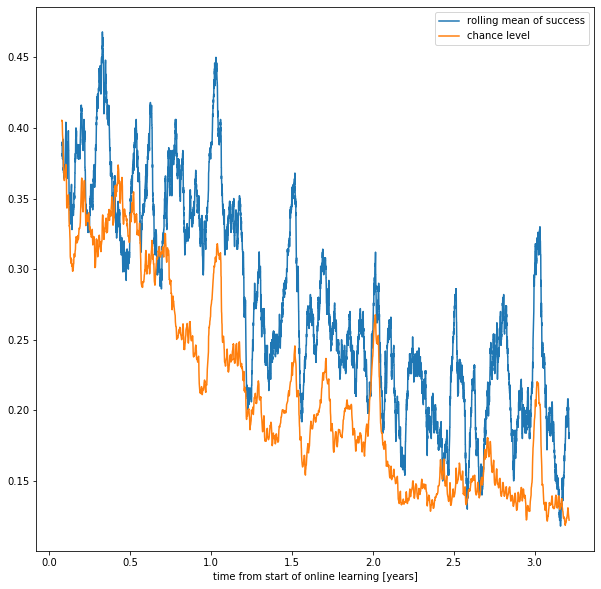

In [7]:
plt.figure(figsize=(10,10))
plt.plot(time_indx.values, r_mean, label='rolling mean of success')
plt.plot(time_indx.values, c_mean, label='chance level')
plt.legend()
plt.xlabel("time from start of online learning [years]")

Text(0.5, 0, 'time from start of online learning [years]')

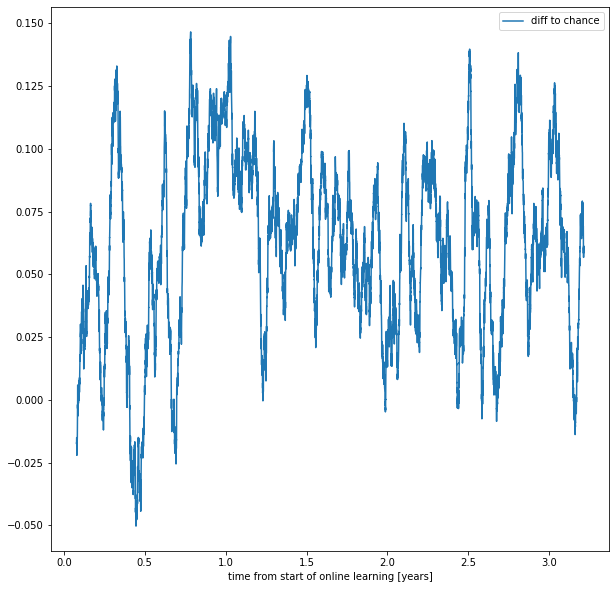

In [10]:
plt.figure(figsize=(10,10))
plt.plot(time_indx.values, r_mean-c_mean, label='diff to chance')
plt.legend()
plt.xlabel("time from start of online learning [years]")

In [8]:
gpr = GaussianProcessRegressor(kernel=DotProduct(), random_state=0, alpha=1e-5)

In [9]:
vals = training_set_for_gp.values
l = np.array(observed_labels)
nnn = 70000
vals, l = vals[nnn:], l[nnn:]
vals.shape

NameError: name 'training_set_for_gp' is not defined

In [12]:
DotProduct()(vals)

array([[42296.        ,  8152.        ,  8152.        , ...,
         5347.        , 17587.        , 17587.        ],
       [ 8152.        ,  8153.00010851,  8153.00010851, ...,
         5347.        ,  5347.        ,  5347.        ],
       [ 8152.        ,  8153.00010851,  8153.00010851, ...,
         5347.        ,  5347.        ,  5347.        ],
       ...,
       [ 5347.        ,  5347.        ,  5347.        , ...,
         3770.        ,  3770.        ,  3770.        ],
       [17587.        ,  5347.        ,  5347.        , ...,
         3770.        ,  8158.        ,  8158.        ],
       [17587.        ,  5347.        ,  5347.        , ...,
         3770.        ,  8158.        ,  8158.        ]])

In [13]:
gpr.fit(vals, l)

GaussianProcessRegressor(alpha=1e-05, copy_X_train=True,
                         kernel=DotProduct(sigma_0=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=0)

In [15]:
mu, sigma = gpr.predict(vals[-10:, :], return_std=True)

/Users/clemens/.pyenv/versions/3.7.0/envs/heckoverflow/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
